# Basketball Free Throw: Speed vs Angle Map

This notebook plots the combinations of launch speed (x-axis) and launch angle (y-axis) that allow a basketball to just pass through the hoop for three lateral alignments of the ball center:

- Front edge of the rim
- Rim center
- Back edge of the rim

Assumptions:
- 2D vertical plane shot (no lateral offset), no air resistance.
- Standard sizes: ball radius = 0.12 m, hoop inner radius = 0.23 m, hoop height = 3.05 m.
- The shooter releases at height `xx` and horizontal distance `yy` from the hoop post (rim center projection).

How it works:
- For a given launch angle θ, we compute the minimum initial speed v such that the ball center passes exactly through the target point (front/center/back) in height and slope constraints (clearance), accounting for the ball radius horizontally.
- We repeat over a range of angles to trace the three curves.

Edit the parameters `xx` and `yy` in the next cell to explore different setups.

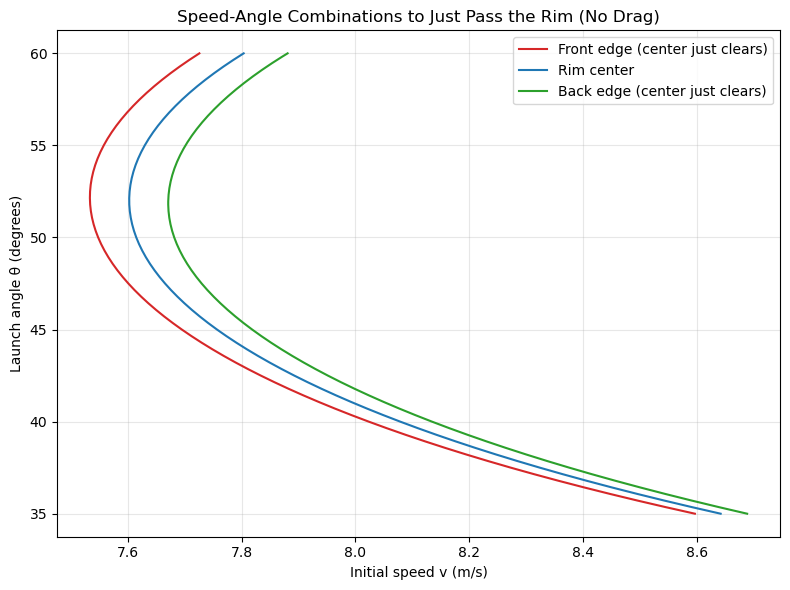

Release height xx = 1.9 m, Distance yy = 4.6 m
Targets x (m): front=4.49, center=4.60, back=4.71


In [2]:
# Parameters (edit these)
xx = 1.9  # release height in meters (e.g., 1.9 m)
yy = 4.6  # horizontal distance to rim center in meters (e.g., 4.6 m)

# Constants
import numpy as np
import matplotlib.pyplot as plt

g = 9.81  # gravity (m/s^2)
R_ball = 0.12  # basketball radius (m)
R_rim = 0.23  # hoop inner radius (m)
H_rim = 3.05  # hoop height (m)

# Numerical setup
# angles_deg = np.linspace(10, 80, 141)  # launch angles to evaluate
angles_deg = np.linspace(35, 60, 141)  # launch angles to evaluate

# Geometry of target x-locations for ball center when it just passes the rim
# When the ball center aligns with:
# - front edge: x_target = yy - R_rim + R_ball
# - rim center: x_target = yy
# - back edge:  x_target = yy + R_rim - R_ball
x_front = yy - R_rim + R_ball
x_center = yy
x_back = yy + R_rim - R_ball

# Safety: ensure targets are in front of the shooter
for name, x_t in [("front", x_front), ("center", x_center), ("back", x_back)]:
    if x_t <= 0:
        raise ValueError(
            f"The computed {name} target x = {x_t:.2f} m is not in front of the shooter. Increase yy or adjust radii."
        )

# For projectile motion without drag:
# y(x) = xx + x*tanθ - (g x^2) / (2 v^2 cos^2θ)
# To pass exactly through the rim height H_rim at x = x_target, solve for minimal v.
# Rearranging gives: v^2 = (g x_target^2) / [2 cos^2θ (xx + x_target tanθ - H_rim)]
# This requires the denominator to be positive.


def required_speed_for_hit(theta_rad, x_target, H_target):
    c = np.cos(theta_rad)
    s = np.sin(theta_rad)
    tan = s / c
    denom = 2 * (c**2) * (xx + x_target * tan - H_target)
    if denom <= 0:
        return np.nan
    v_sq = g * x_target**2 / denom
    if v_sq <= 0:
        return np.nan
    return np.sqrt(v_sq)


# Compute minimal speeds across angles for each alignment
v_front = np.array(
    [required_speed_for_hit(np.deg2rad(a), x_front, H_rim) for a in angles_deg]
)
v_center = np.array(
    [required_speed_for_hit(np.deg2rad(a), x_center, H_rim) for a in angles_deg]
)
v_back = np.array(
    [required_speed_for_hit(np.deg2rad(a), x_back, H_rim) for a in angles_deg]
)

# Filter angles where solution is feasible
mask_front = np.isfinite(v_front)
mask_center = np.isfinite(v_center)
mask_back = np.isfinite(v_back)

# Plot: x-axis speed (m/s), y-axis angle (deg)
plt.figure(figsize=(8, 6))
plt.plot(
    v_front[mask_front],
    angles_deg[mask_front],
    label="Front edge (center just clears)",
    color="#d62728",
)
plt.plot(
    v_center[mask_center], angles_deg[mask_center], label="Rim center", color="#1f77b4"
)
plt.plot(
    v_back[mask_back],
    angles_deg[mask_back],
    label="Back edge (center just clears)",
    color="#2ca02c",
)

plt.xlabel("Initial speed v (m/s)")
plt.ylabel("Launch angle θ (degrees)")
plt.title("Speed-Angle Combinations to Just Pass the Rim (No Drag)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Print a quick summary of parameterization
print(f"Release height xx = {xx} m, Distance yy = {yy} m")
print(f"Targets x (m): front={x_front:.2f}, center={x_center:.2f}, back={x_back:.2f}")

## Notes

- Change `xx` (release height) and `yy` (horizontal distance to rim center) at the top of the code cell.
- The three curves show the minimum speed needed at each angle to have the ball center cross the hoop plane at front edge, center, and back edge levels, respectively, accounting for ball radius in the horizontal offsets.
- If a curve disappears in a certain angle band, it means the geometry/angle cannot reach that point with a physical parabolic arc that still intersects at the rim height (the denominator condition turns non-positive).
- Model ignores air resistance and ball spin, so real-world required speeds will be slightly higher.


## 多距离的最佳角度与速度

下面的图会在同一张图中显示：
- 固定同一出手高度 `xx`，针对多个不同的水平距离 `yy_values`；
- 每个距离下，随发射角度变化所需的最小初速度曲线；
- 以及该距离下的“最佳点”（使所需初速度最小的角度与速度）。

可在下一单元格顶部编辑：
- `xx` 出手高度（米）
- `yy_values` 距离数组（米）
- `alignment` 取值 `'front' | 'center' | 'back'`（分别对应篮圈前沿/中心/后沿的穿越平面）
- `angles_deg` 角度扫描范围（度）

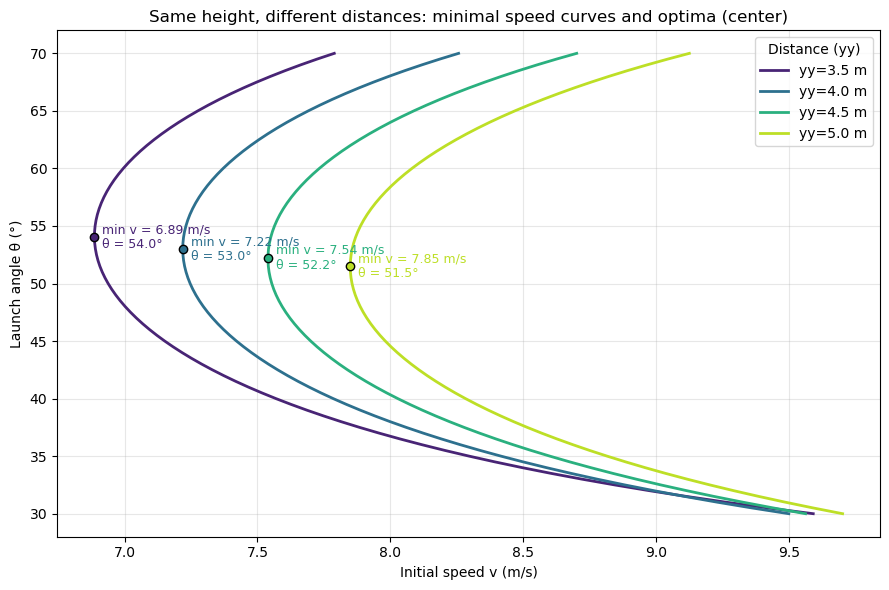

yy=3.50 m -> min speed 6.89 m/s @ angle 54.0° (center)
yy=4.00 m -> min speed 7.22 m/s @ angle 53.0° (center)
yy=4.50 m -> min speed 7.54 m/s @ angle 52.2° (center)
yy=5.00 m -> min speed 7.85 m/s @ angle 51.5° (center)


In [ ]:
# Multi-distance: same release height, different distances on one figure (English labels)
import numpy as np
import matplotlib.pyplot as plt

# Editable parameters
xx = 1.9  # release height (m)
yy_values = [3.5, 4.0, 4.5, 5.0]  # distances (m)
alignment = "center"  # 'front' | 'center' | 'back'
angles_deg = np.linspace(30, 70, 161)  # angle sweep (degrees)

# Constants
g = 9.81
R_ball = 0.12
R_rim = 0.23
H_rim = 3.05


# Target x based on alignment
def x_target_for_alignment(yy, align):
    if align == "front":
        return yy - R_rim + R_ball
    elif align == "center":
        return yy
    elif align == "back":
        return yy + R_rim - R_ball
    else:
        raise ValueError("alignment must be one of 'front' | 'center' | 'back'")


# Required speed to hit H_target at x_target for a given theta
def required_speed_for_hit(theta_rad, x_target, H_target):
    c = np.cos(theta_rad)
    s = np.sin(theta_rad)
    tan = s / c
    denom = 2 * (c**2) * (xx + x_target * tan - H_target)
    if denom <= 0:
        return np.nan
    v_sq = g * x_target**2 / denom
    if v_sq <= 0:
        return np.nan
    return np.sqrt(v_sq)


plt.figure(figsize=(9, 6))
colors = plt.cm.viridis(np.linspace(0.1, 0.9, len(yy_values)))

best_points = []  # (yy, v_min, ang_at_min)

for yy, color in zip(yy_values, colors):
    x_t = x_target_for_alignment(yy, alignment)
    if x_t <= 0:
        print(f"Skip yy={yy:.2f} m: target x={x_t:.2f} m is not in front of shooter")
        continue

    v_list = np.array(
        [required_speed_for_hit(np.deg2rad(a), x_t, H_rim) for a in angles_deg]
    )
    mask = np.isfinite(v_list)

    if not np.any(mask):
        print(f"No feasible solution within scanned angles for yy={yy:.2f} m")
        continue

    # Plot speed-angle curve (x: v, y: angle)
    plt.plot(v_list[mask], angles_deg[mask], color=color, lw=2, label=f"yy={yy:.1f} m")

    # Find minimal speed point
    idx = np.nanargmin(v_list)
    v_min = v_list[idx]
    ang_min = angles_deg[idx]
    best_points.append((yy, v_min, ang_min))

    # Annotate the optimal point
    plt.scatter([v_min], [ang_min], color=color, edgecolor="k", zorder=3)
    plt.text(
        v_min,
        ang_min,
        f"  min v = {v_min:.2f} m/s\n  θ = {ang_min:.1f}°",
        va="center",
        ha="left",
        fontsize=9,
        color=color,
    )

plt.xlabel("Initial speed v (m/s)")
plt.ylabel("Launch angle θ (°)")
plt.title(
    f"Same height, different distances: minimal speed curves and optima ({alignment})"
)
plt.grid(True, alpha=0.3)
plt.legend(title="Distance (yy)")
plt.tight_layout()
plt.show()

# Summary printout
for yy, v_min, ang_min in best_points:
    print(
        f"yy={yy:.2f} m -> min speed {v_min:.2f} m/s @ angle {ang_min:.1f}° ({alignment})"
    )

## Optimal speed and angle table (multi heights & distances)

This section computes, for each combination of release height and distance, the angle that minimizes the required initial speed (to pass the chosen rim alignment), and outputs a table with:
- height xx (m)
- distance yy (m)
- optimal angle θ_opt (deg)
- minimal speed v_min (m/s)

Edit the parameters in the next cell:
- `xx_values`: a list of heights (m)
- `yy_values`: a list of distances (m)
- `alignment`: 'front' | 'center' | 'back'
- `angles_deg`: search angle range (deg)

The physics matches earlier cells (no drag, standard sizes).

In [ ]:
# Compute optimal speed and angle for multiple heights (xx) and distances (yy)
import numpy as np

# Editable parameters
xx_values = [1.6, 1.8, 2.0]  # heights (m)
yy_values = [3.5, 4.0, 4.5, 5.0]  # distances (m)
alignment = "center"  # 'front' | 'center' | 'back'
angles_deg = np.linspace(30, 70, 161)  # search range (deg)

# Constants
g = 9.81
R_ball = 0.12
R_rim = 0.23
H_rim = 3.05


# Helper functions
def x_target_for_alignment(yy, align):
    if align == "front":
        return yy - R_rim + R_ball
    elif align == "center":
        return yy
    elif align == "back":
        return yy + R_rim - R_ball
    else:
        raise ValueError("alignment must be one of 'front' | 'center' | 'back'")


def required_speed_for_hit(xx, theta_rad, x_target, H_target):
    c = np.cos(theta_rad)
    s = np.sin(theta_rad)
    tan = s / c
    denom = 2 * (c**2) * (xx + x_target * tan - H_target)
    if denom <= 0:
        return np.nan
    v_sq = g * x_target**2 / denom
    if v_sq <= 0:
        return np.nan
    return np.sqrt(v_sq)


# Compute table rows
rows = []
for xx in xx_values:
    for yy in yy_values:
        x_t = x_target_for_alignment(yy, alignment)
        if x_t <= 0:
            rows.append(
                {
                    "height_m": xx,
                    "distance_m": yy,
                    "theta_opt_deg": np.nan,
                    "v_min_mps": np.nan,
                    "note": "target x behind shooter",
                }
            )
            continue
        v_list = np.array(
            [required_speed_for_hit(xx, np.deg2rad(a), x_t, H_rim) for a in angles_deg]
        )
        if not np.any(np.isfinite(v_list)):
            rows.append(
                {
                    "height_m": xx,
                    "distance_m": yy,
                    "theta_opt_deg": np.nan,
                    "v_min_mps": np.nan,
                    "note": "no feasible angle in range",
                }
            )
            continue
        idx = np.nanargmin(v_list)
        rows.append(
            {
                "height_m": xx,
                "distance_m": yy,
                "theta_opt_deg": float(angles_deg[idx]),
                "v_min_mps": float(v_list[idx]),
                "note": "",
            }
        )

# Display as a simple table without extra deps
# Sort by height then distance
rows_sorted = sorted(rows, key=lambda r: (r["height_m"], r["distance_m"]))

# Pretty print header
headers = ["height_m", "distance_m", "theta_opt_deg", "v_min_mps", "note"]
col_widths = [
    max(
        len(h),
        max(
            (
                len(f"{r[h]:.2f}") if isinstance(r[h], float) else len(str(r[h]))
                for r in rows_sorted
            ),
            default=0,
        ),
    )
    for h in headers
]


# Format a row
def fmt_val(v):
    if isinstance(v, float) and not np.isnan(v):
        return f"{v:.2f}"
    return str(v)


header_line = " | ".join(h.ljust(w) for h, w in zip(headers, col_widths))
sep_line = "-+-".join("-" * w for w in col_widths)
print(header_line)
print(sep_line)
for r in rows_sorted:
    print(" | ".join(fmt_val(r[h]).ljust(w) for h, w in zip(headers, col_widths)))

# Also make a small dict list available as `optimal_table` for further use
optimal_table = rows_sorted

height_m | distance_m | theta_opt_deg | v_min_mps | note
---------+------------+---------------+-----------+-----
1.60     | 3.50       | 56.25         | 7.17      |     
1.60     | 4.00       | 55.00         | 7.48      |     
1.60     | 4.50       | 54.00         | 7.78      |     
1.60     | 5.00       | 53.00         | 8.08      |     
1.80     | 3.50       | 54.75         | 6.98      |     
1.80     | 4.00       | 53.75         | 7.31      |     
1.80     | 4.50       | 52.75         | 7.62      |     
1.80     | 5.00       | 52.00         | 7.93      |     
2.00     | 3.50       | 53.25         | 6.79      |     
2.00     | 4.00       | 52.25         | 7.13      |     
2.00     | 4.50       | 51.50         | 7.46      |     
2.00     | 5.00       | 51.00         | 7.77      |     


## Fixed height: optimal speed/angle vs distance

This section fixes the release height and scans multiple distances. For each distance we find the angle that minimizes the required speed (for a chosen alignment), then plot:
- v_min vs distance
- θ_opt vs distance
- A parametric curve on one figure with x = v_min and y = θ_opt, labeled by distance

Edit the parameters at the top of the next cell.

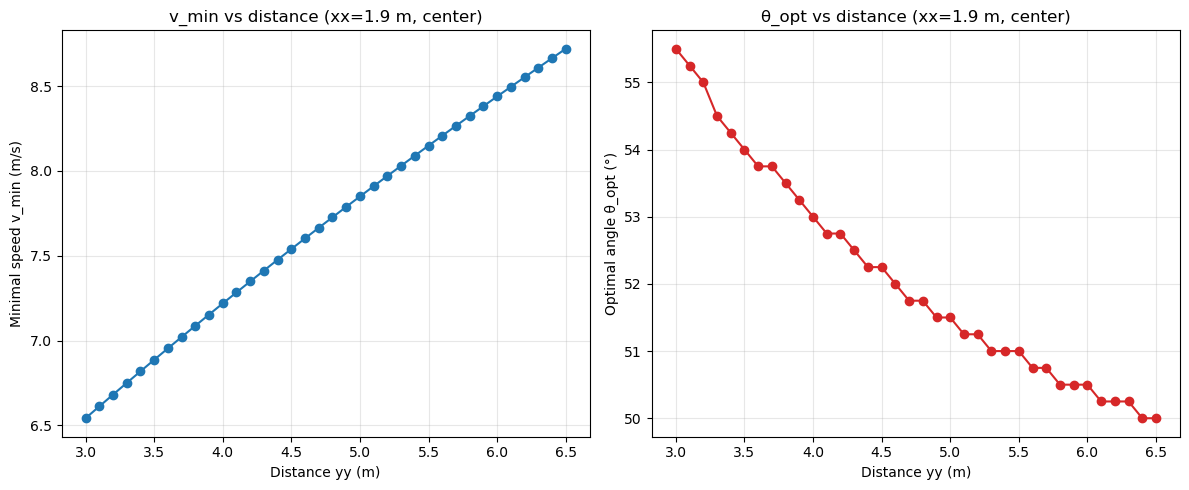

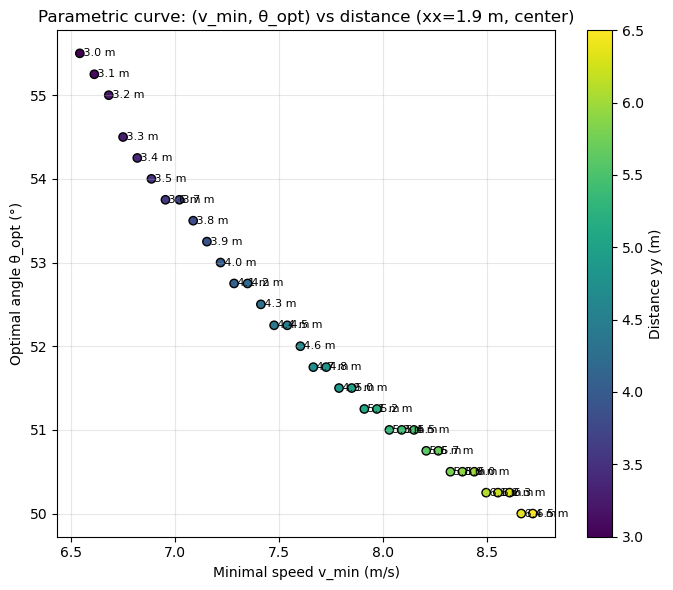

In [ ]:
# Fixed height, varying distance: optimal speed and angle curves
import numpy as np
import matplotlib.pyplot as plt

# Editable parameters
xx = 1.9  # fixed release height (m)
yy_values = np.linspace(3.0, 6.5, 36)  # distance sweep (m)
alignment = "center"  # 'front' | 'center' | 'back'
angles_deg = np.linspace(30, 70, 161)  # angle sweep (deg)

# Constants
g = 9.81
R_ball = 0.12
R_rim = 0.23
H_rim = 3.05


# Helpers
def x_target_for_alignment(yy, align):
    if align == "front":
        return yy - R_rim + R_ball
    elif align == "center":
        return yy
    elif align == "back":
        return yy + R_rim - R_ball
    else:
        raise ValueError("alignment must be one of 'front' | 'center' | 'back'")


def required_speed_for_hit(theta_rad, x_target, H_target):
    c = np.cos(theta_rad)
    s = np.sin(theta_rad)
    tan = s / c
    denom = 2 * (c**2) * (xx + x_target * tan - H_target)
    if denom <= 0:
        return np.nan
    v_sq = g * x_target**2 / denom
    if v_sq <= 0:
        return np.nan
    return np.sqrt(v_sq)


v_min_list = []
ang_opt_list = []
yy_feasible = []

for yy in yy_values:
    x_t = x_target_for_alignment(yy, alignment)
    if x_t <= 0:
        v_min_list.append(np.nan)
        ang_opt_list.append(np.nan)
        continue
    v_list = np.array(
        [required_speed_for_hit(np.deg2rad(a), x_t, H_rim) for a in angles_deg]
    )
    if not np.any(np.isfinite(v_list)):
        v_min_list.append(np.nan)
        ang_opt_list.append(np.nan)
        continue
    idx = np.nanargmin(v_list)
    v_min_list.append(v_list[idx])
    ang_opt_list.append(angles_deg[idx])
    yy_feasible.append(yy)

v_min = np.array(v_min_list)
ang_opt = np.array(ang_opt_list)

# Plot v_min vs distance and θ_opt vs distance
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].plot(yy_values, v_min, "o-", color="#1f77b4")
axes[0].set_xlabel("Distance yy (m)")
axes[0].set_ylabel("Minimal speed v_min (m/s)")
axes[0].set_title(f"v_min vs distance (xx={xx} m, {alignment})")
axes[0].grid(True, alpha=0.3)

axes[1].plot(yy_values, ang_opt, "o-", color="#d62728")
axes[1].set_xlabel("Distance yy (m)")
axes[1].set_ylabel("Optimal angle θ_opt (°)")
axes[1].set_title(f"θ_opt vs distance (xx={xx} m, {alignment})")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Parametric plot (v_min vs θ_opt), colored by distance
plt.figure(figsize=(7, 6))
mask = np.isfinite(v_min) & np.isfinite(ang_opt)
sc = plt.scatter(
    v_min[mask], ang_opt[mask], c=yy_values[mask], cmap="viridis", edgecolor="k"
)
for v, a, y in zip(v_min[mask], ang_opt[mask], yy_values[mask]):
    plt.text(v, a, f" {y:.1f} m", va="center", fontsize=8)
plt.colorbar(sc, label="Distance yy (m)")
plt.xlabel("Minimal speed v_min (m/s)")
plt.ylabel("Optimal angle θ_opt (°)")
plt.title(f"Parametric curve: (v_min, θ_opt) vs distance (xx={xx} m, {alignment})")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()